In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D, Conv2D, concatenate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
# Load class mapping from CSV
csv_path = '/content/drive/MyDrive/ayrik1/class_dict_seg.csv'
class_df = pd.read_csv(csv_path)
colormap = {tuple(class_df.loc[i, [' r', ' g', ' b']]): i for i in range(len(class_df))}

In [4]:
# Convert RGB mask to class indices
def rgb_to_class(mask, colormap):
    shape = mask.shape[:2]
    class_map = np.zeros(shape, dtype=int)
    for rgb, idx in colormap.items():
        class_map[np.all(mask == rgb, axis=-1)] = idx
    return class_map


In [5]:
def load_images_and_masks(images_path, masks_path, size=(224, 224), mask_ext='.png'):
    images = []
    masks = []
    for img_name in os.listdir(images_path):
        img_path = os.path.join(images_path, img_name)
        mask_name = os.path.splitext(img_name)[0] + mask_ext
        mask_path = os.path.join(masks_path, mask_name)  # Adjust for the mask extension

        if os.path.exists(mask_path):
            img = load_img(img_path, target_size=size)
            img = img_to_array(img)
            images.append(img)

            mask = load_img(mask_path, target_size=size, color_mode="grayscale")
            mask = img_to_array(mask)
            masks.append(mask)
        else:
            print(f"Mask for image {img_name} not found.")

    return np.array(images), np.array(masks)

# Paths to images and masks
images_path = '/content/drive/MyDrive/ayrik1/original_images'
masks_path = '/content/drive/MyDrive/ayrik1/label_images_semantic'

# Load images and masks
images, masks = load_images_and_masks(images_path, masks_path)

# Normalize images
images = images / 255.0

# Convert masks to integer and remove any extra channels
masks = masks.astype(int)
if masks.shape[-1] == 3:  # Assuming masks have 3 channels
    masks = masks[:, :, :, 0]  # Use only the first channel

# Check if masks are correct
print(f"Unique values in masks before one-hot encoding: {np.unique(masks)}")

# One-hot encode the masks
num_classes = np.max(masks) + 1 if np.max(masks) > 0 else 1
masks = tf.keras.utils.to_categorical(masks, num_classes=num_classes)

# Ensure masks have the shape (num_samples, 224, 224, num_classes)
print(f"Shape of masks after one-hot encoding: {masks.shape}")

Unique values in masks before one-hot encoding: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Shape of masks after one-hot encoding: (78, 224, 224, 23)


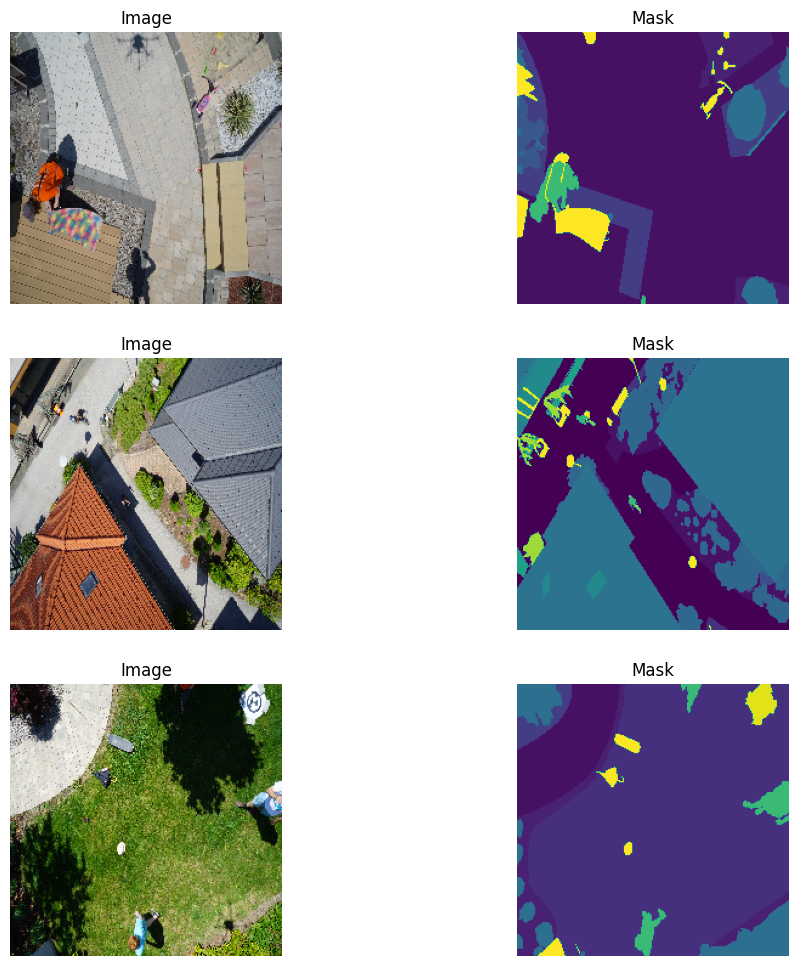

In [6]:
# Display a few images and their corresponding masks
def display_images_and_masks(images, masks, num_images=3):
    plt.figure(figsize=(12, num_images * 4))
    for i in range(num_images):
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis('off')

        plt.subplot(num_images, 2, i * 2 + 2)
        plt.imshow(np.argmax(masks[i], axis=-1))
        plt.title("Mask")
        plt.axis('off')
    plt.show()

# Display a few examples
display_images_and_masks(images, masks)

In [7]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [8]:
# Define the VGG16 U-Net model
def build_vgg16_unet(input_shape, num_classes):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Encoder
    for layer in vgg16.layers:
        layer.trainable = False

    # Decoder
    x = vgg16.output

    # Decoder block 1
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    skip_connection = vgg16.get_layer('block5_conv3').output
    x = concatenate([x, skip_connection])

    # Decoder block 2
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    skip_connection = vgg16.get_layer('block4_conv3').output
    x = concatenate([x, skip_connection])

    # Decoder block 3
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    skip_connection = vgg16.get_layer('block3_conv3').output
    x = concatenate([x, skip_connection])

    # Decoder block 4
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    skip_connection = vgg16.get_layer('block2_conv2').output
    x = concatenate([x, skip_connection])

    # Decoder block 5
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    skip_connection = vgg16.get_layer('block1_conv2').output
    x = concatenate([x, skip_connection])

    x = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    return Model(inputs=vgg16.input, outputs=x)


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
4/4 [==============================] - 53s 8s/step - loss: 13.8687 - accuracy: 0.1644 - val_loss: 5.2328 - val_accuracy: 0.0959
Epoch 2/20
4/4 [==============================] - 2s 512ms/step - loss: 5.2224 - accuracy: 0.2083 - val_loss: 4.2617 - val_accuracy: 0.2755
Epoch 3/20
4/4 [==============================] - 2s 513ms/step - loss: 4.0121 - accuracy: 0.2595 - val_loss: 3.6775 - val_accuracy: 0.3579
Epoch 4/20
4/4 [==============================] - 2s 513ms/step - loss: 3.3025 - accuracy: 0.3138 - val_loss: 3.0214 - val_accuracy: 0.2950
Epoch 5/20
4/4 [==============================] - 2s 532ms/step - loss: 2.7693 - accuracy: 0.3843 - val_loss: 2.7188 - val_accuracy: 0.4486
Epoch 6/20
4/4 [==============================] - 2s 545ms/step - loss: 2.4005 - accuracy: 0.4590 - val_loss: 2.3943 - val_accuracy: 0.4214
Epoch 7/20
4/4 [==============================] - 2s 506ms/step - loss: 2.1361 - accuracy: 0.469

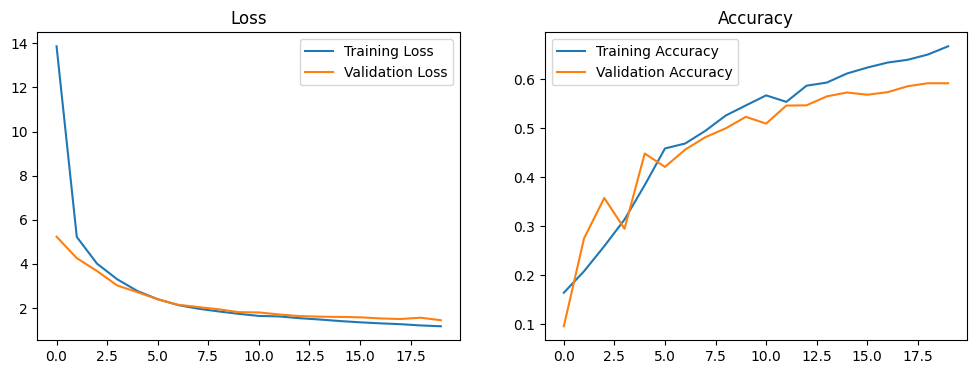

In [9]:
# Build and compile the model
input_shape = (224, 224, 3)
model = build_vgg16_unet(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16)

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)


In [10]:
# Function to display results
def display_results(image, mask, prediction):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(np.argmax(mask, axis=-1))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(np.argmax(prediction, axis=-1))
    plt.axis('off')

    plt.show()

1/1 [==============================] - 2s 2s/step


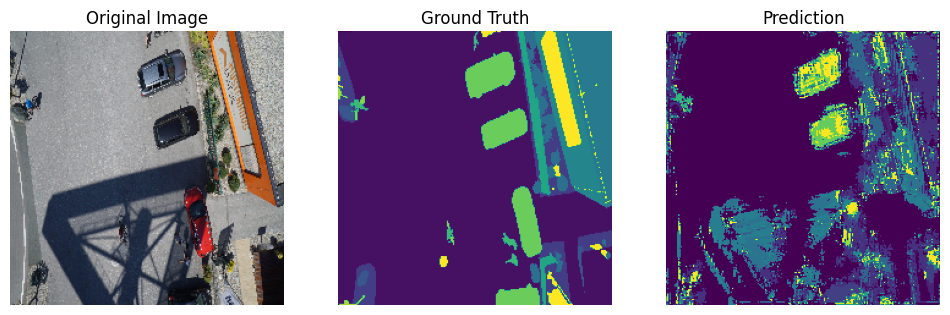

In [11]:
# Predict on a validation image
sample_image = X_val[0]
sample_mask = y_val[0]
sample_pred = model.predict(np.expand_dims(sample_image, axis=0))

display_results(sample_image, sample_mask, sample_pred[0])